# Kickstarter Success Analysis

This project will analyze the predictors of a successful kickstarter campaign using data from Kickstarter, a global crowdfunding platform. The hope is that, using only the data available about a kickstarter prior to launch, an accurate preditive model can be created to determine the success of failure of the kickstarter campaign.

## About this dataset
Features in the dataset include, but are not limited to the following:

* **deadline**: deadline for completing their crowdfunding
* **launched**: date of kickstarter launch

* **goal**: target fundraising amount in native currency
* **usd_goal_real**: target fundraising amount in USD

* **pledged**: amuont of capital pledged in native currency
* **usd_pledged_real**: amuont of capital pledged in in USD

* **state**: the current state of the fundraising effort
* **Other Features**: ID, name, business category, native currency, number of backers, country,  

The goal of this analysis will be to how well the success or failure of a kickstarter business can be predicted by these factors

## Import Data 

In [1]:
!pip install kaggle

In [2]:
!kaggle datasets list -s "kemical/kickstarter"

ref                                              title                                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------  ----------------------------------------  ----  -------------------  -------------  ---------  ---------------  
tonyplaysguitar/steam-spy-data-from-api-request  Kickstarter videogames released on Steam   1MB  2018-01-21 23:54:08            357         13  0.8235294        
kemical/kickstarter-projects                     Kickstarter Projects                      37MB  2018-02-08 09:02:30          63307       1506  0.7941176        


In [3]:
!kaggle datasets download -d "kemical/kickstarter-projects"

kickstarter-projects.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile as zf
files = zf.ZipFile("kickstarter-projects.zip", "r")
files.extractall()
files.close()

## Load Data into Dataframe 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot") 
import seaborn as sns

In [6]:
csv = "ks-projects-201801.csv"
df = pd.read_csv(csv)

In [7]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Data Wrangling and EDA

#### State
Explore the state of the start-up and narrow the data to only states for analysis (successful and failure)

In [8]:
df["state"].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [9]:
print("Successful:", str(round(df["state"].value_counts()["successful"] / len(df) * 100, 2)) + "%")
print("Failed:", str(round(df["state"].value_counts()["failed"] / len(df) * 100, 2)) + "%")
print("Canceled:", str(round(df["state"].value_counts()["canceled"] / len(df) * 100, 2)) + "%")
print("Undefined:", str(round(df["state"].value_counts()["undefined"] / len(df) * 100, 2)) + "%")
print("Live:", str(round(df["state"].value_counts()["live"] / len(df) * 100, 2)) + "%")
print("Suspended:", str(round(df["state"].value_counts()["suspended"] / len(df) * 100, 2)) + "%")

Successful: 35.38%
Failed: 52.22%
Canceled: 10.24%
Undefined: 0.94%
Live: 0.74%
Suspended: 0.49%


In [10]:
df["state"].replace("suspended", "failed", inplace = True)
df["state"].replace("canceled", "failed", inplace = True)

In [11]:
df = df[df["state"] != "undefined"]
df = df[df["state"] != "live"]

In [12]:
print("Successful", str(round(df["state"].value_counts()["successful"] / len(df) * 100, 2)) + "%")
print("Failed", str(round(df["state"].value_counts()["failed"] / len(df) * 100, 2)) + "%")

Successful 35.98%
Failed 64.02%


#### Goal
Understand the distribution of goals (using <code>usd_goal_real</code>), as well as the distributions of goals for successful and failed start-ups

In [13]:
df["usd_goal_real"].describe()

count    3.723000e+05
mean     4.572162e+04
std      1.151326e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.500000e+03
75%      1.598542e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

Because there appears to be a strong right skew, use plot the distribution of the log values to see if there is lognormal distribution.

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='usd_goal_real', ylabel='Density'>

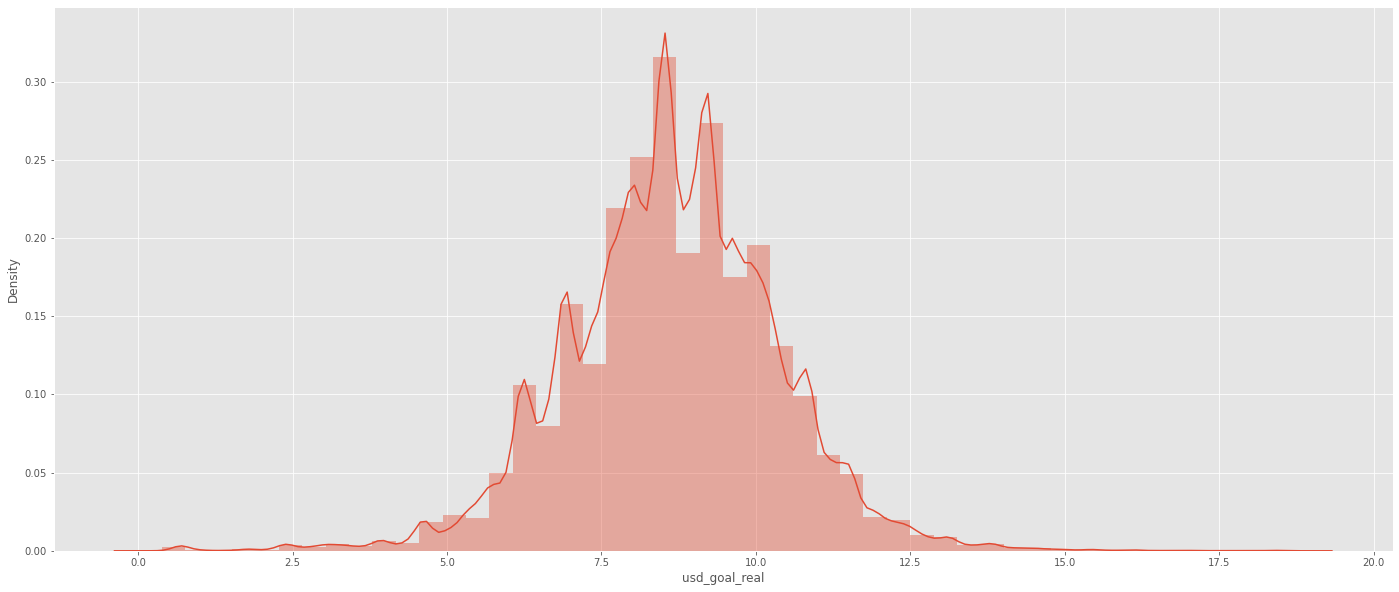

In [14]:
log_goal = np.log(df["usd_goal_real"] + 1)

plt.figure(figsize = (24, 10))
sns.distplot(log_goal)

In [15]:
# Check normalized distribution
from scipy import stats

stat, p = stats.shapiro(log_goal.sample(500, random_state = 42))
print("Shapiro Stat:", stat)
print("p-value:", p)

Shapiro Stat: 0.9779565930366516
p-value: 7.316443202398659e-07


The log of the goals are normally distributed. 

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


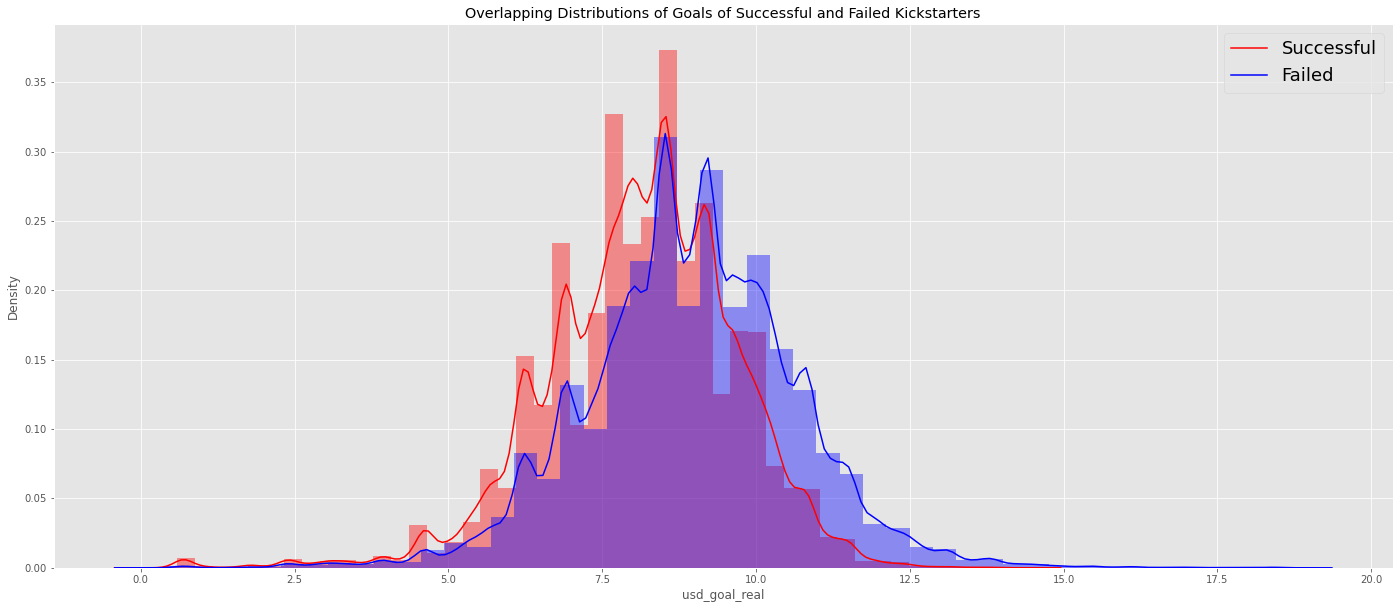

In [16]:
success = df[df["state"] == "successful"]
failed = df[df["state"] == "failed"]

log_success = np.log(success["usd_goal_real"] + 1)
log_failed = np.log(failed["usd_goal_real"] + 1)

plt.figure(figsize = (24, 10))
sns.distplot(log_success, color = "red")
sns.distplot(log_failed, color = "blue")
plt.legend(labels = ["Successful", "Failed"], fontsize = 18)
plt.title("Overlapping Distributions of Goals of Successful and Failed Kickstarters")

plt.show()

In [17]:
print("p-value of 2-Sample T-Test <", stats.ttest_ind(log_success, log_failed)[1])

p-value of 2-Sample T-Test < 0.0


There is also normal distribution for both successful and failed states. It also shows that those kickstarters that failed appear to have higher goals.

Add new useful columns: log of usd_goal_real, log of usd_pledged_real, and the percent difference between the pleged and goal amount 

In [18]:
df["goal_log"] = np.log(df["usd_goal_real"] + 1)
df["pledged_log"] = np.log(df["usd_pledged_real"] + 1)
df["pledge_diff"] = round(df["usd_pledged_real"] / df["usd_goal_real"] * 100, 2)

In [19]:
success = df[df["state"] == "successful"]
failed = df[df["state"] == "failed"]

Visualize differences between the goal and pledge amounts for successful and failed kickstarters

(-5.0, 20.0)

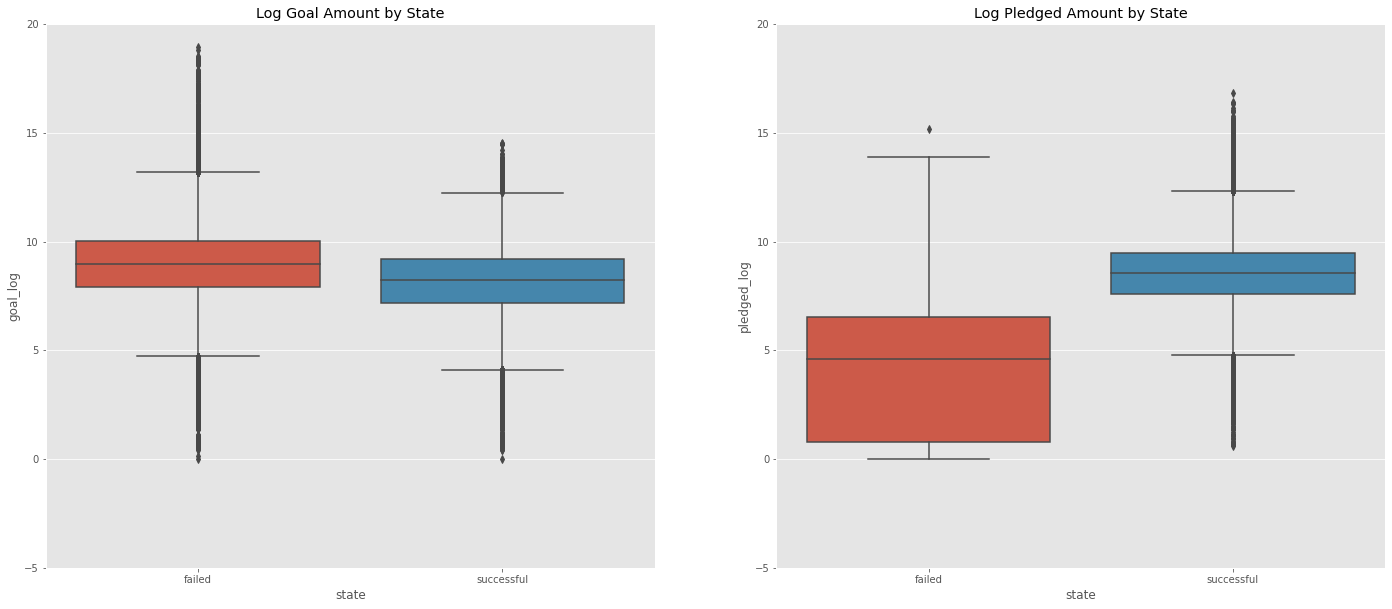

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (24, 10))

sns.boxplot(data = df, x = "state", y = "goal_log", ax = ax[0])
ax[0].set_title("Log Goal Amount by State")
ax[0].set_ylim(-5, 20)

sns.boxplot(data = df, x = "state", y = "pledged_log", ax = ax[1])
ax[1].set_title("Log Pledged Amount by State")
ax[1].set_ylim(-5, 20)

As can be seen by the boxplots, not only did failed kickstarters have higher goals, but they also received less pledged capital.

#### Category & Main Category

* Relative number of kickstarters for each category
* Distribution of state for each category

In [21]:
main_cat = df["main_category"].value_counts().sort_values(ascending = False)
main_cat_success = success["main_category"].value_counts().sort_values(ascending = False)
main_cat_failed = failed["main_category"].value_counts().sort_values(ascending = False)

Text(0.5, 1.0, 'Main Category Count (entire dataset)')

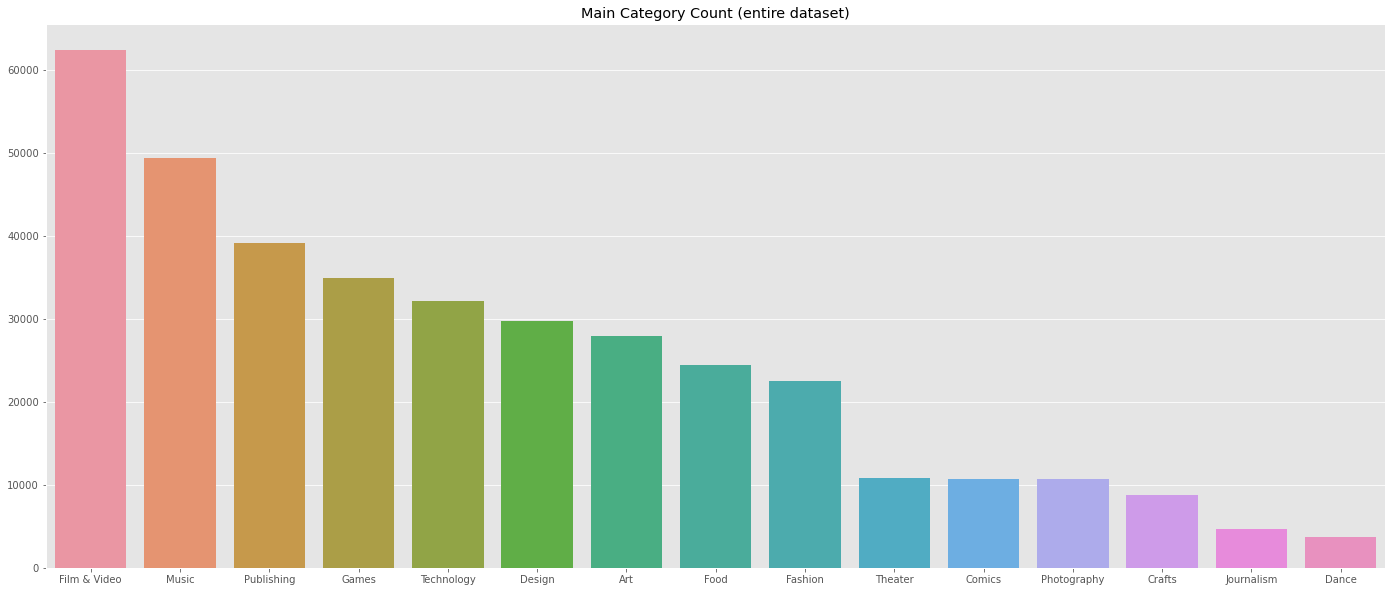

In [22]:
plt.figure(figsize = (24, 10))
sns.barplot(x = main_cat.keys(), y = main_cat.values)
plt.title("Main Category Count (entire dataset)")

Text(0.5, 1.0, 'Failed Percent by Main Category')

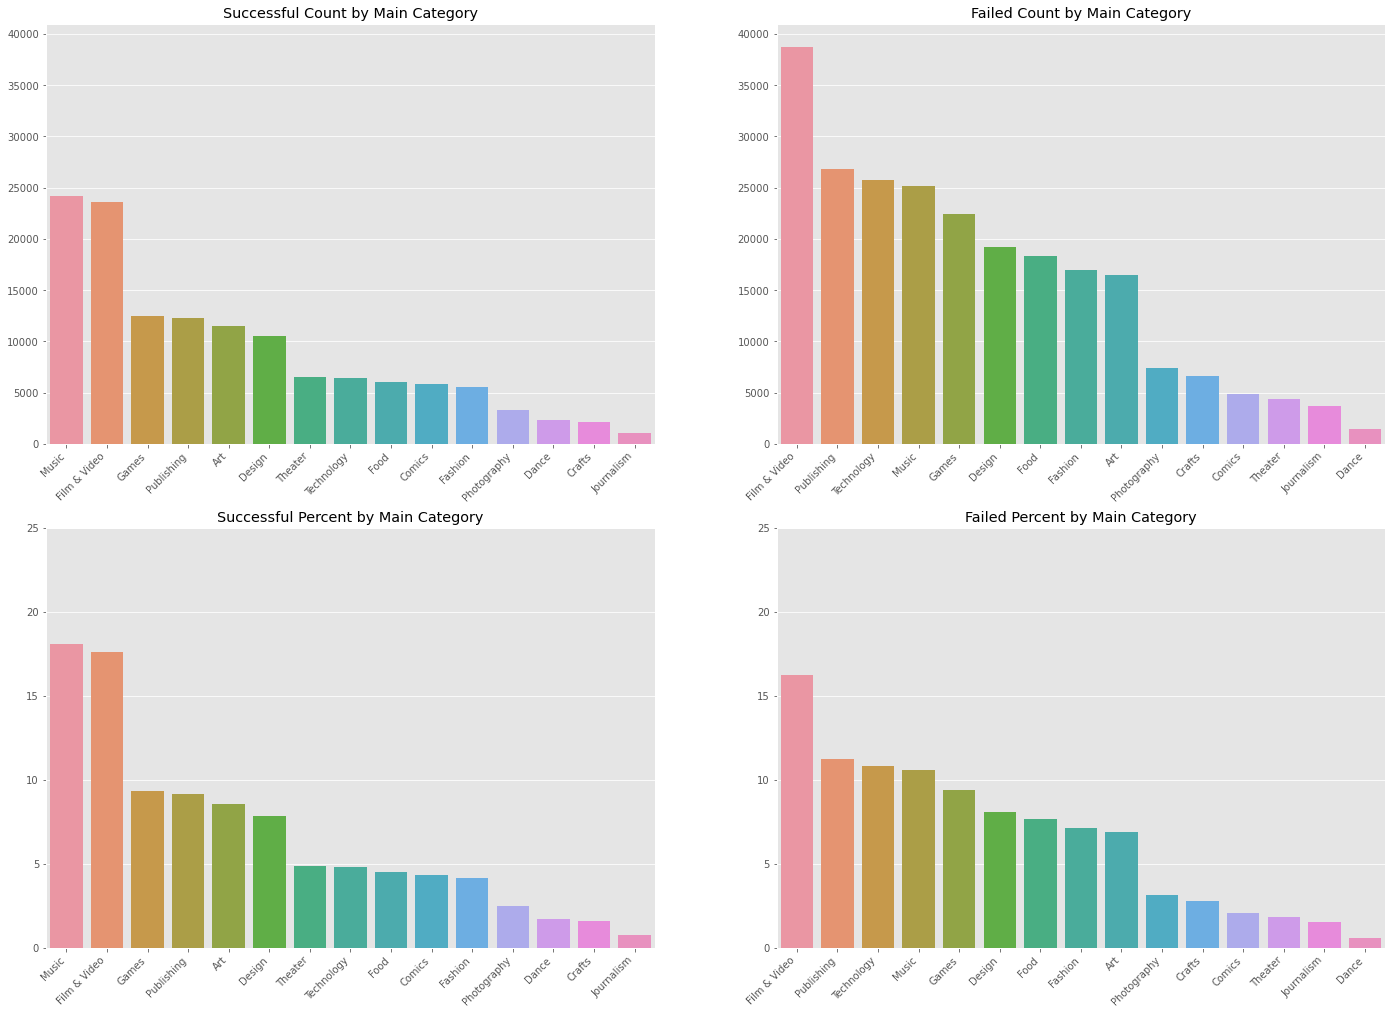

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (24, 17))

# Main Category Count: Success & Failure 

sns.barplot(x = main_cat_success.keys(), y = main_cat_success.values, ax = ax1[0])
ax1[0].set_xticklabels(ax1[0].get_xticklabels(), rotation = 45, ha = "right")
ax1[0].set_ylim(0, 41000)
ax1[0].set_title("Successful Count by Main Category")

sns.barplot(x = main_cat_failed.keys(), y = main_cat_failed.values, ax = ax1[1])
ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation = 45, ha = "right")
ax1[1].set_ylim(0, 41000)
ax1[1].set_title("Failed Count by Main Category")

# Main Category Percent: Success & Failure 

success_pct = round(main_cat_success / main_cat_success.sum() * 100, 2)
failed_pct = round(main_cat_failed / main_cat_failed.sum() * 100, 2)

sns.barplot(x = main_cat_success.keys(), y = success_pct.values, ax = ax2[0])
ax2[0].set_xticklabels(ax2[0].get_xticklabels(), rotation = 45, ha = "right")
ax2[0].set_ylim(0, 25)
ax2[0].set_title("Successful Percent by Main Category")

sns.barplot(x = main_cat_failed.keys(), y = failed_pct.values, ax = ax2[1])
ax2[1].set_xticklabels(ax2[1].get_xticklabels(), rotation = 45, ha = "right")
ax2[1].set_ylim(0, 25)
ax2[1].set_title("Failed Percent by Main Category")

In [24]:
stat, p, dof, expected = stats.chi2_contingency([main_cat_success.values, main_cat_failed.values])
print("Degrees of Freedom =", dof)
print("stat =", stat)
print("p-value =", p)

Degrees of Freedom = 14
stat = 6680.103018074855
p-value = 0.0


There appear to be differences in states of successful and failed kickstarters, with the the most glaring differences being Music, which is over-represented among successful kickstarters, and Technology, which is over-represented among failed kickstarters.

Now we can check if the more granular categories show differnces 

In [25]:
# Top 10 most common categories among success and failed 
cat_all = df["category"].value_counts()
cat_success = success["category"].value_counts()
cat_failed = failed["category"].value_counts()

Text(0.5, 1.0, 'Category Count (entire dataset)')

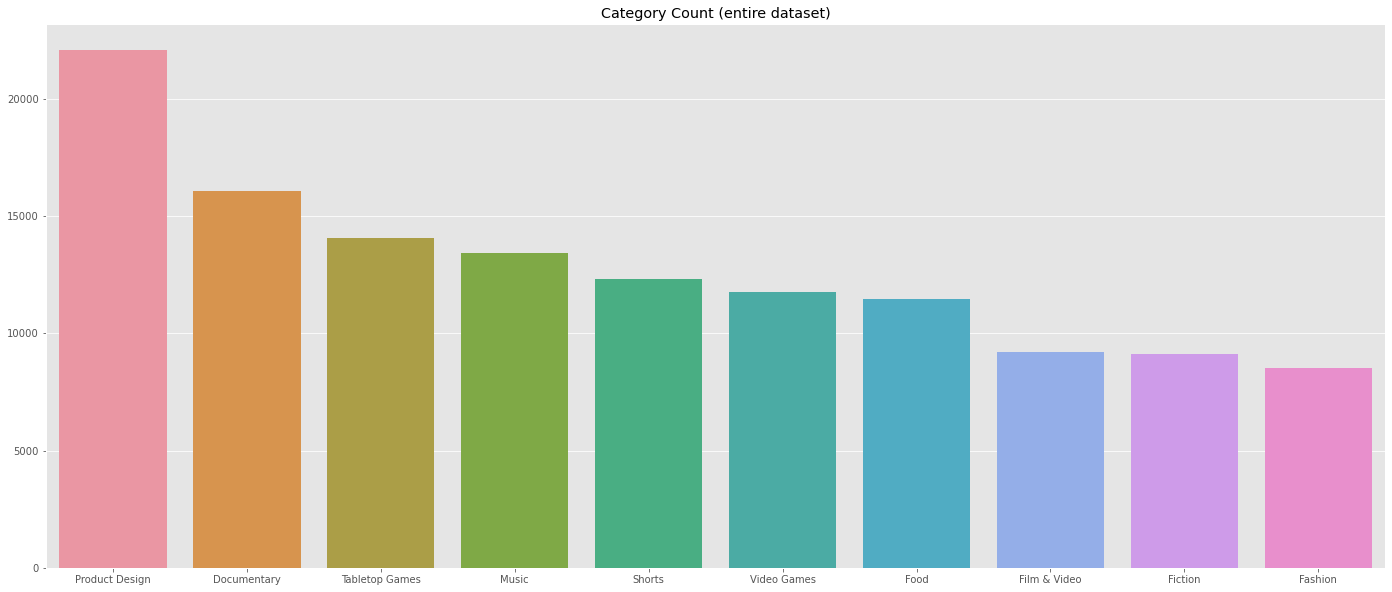

In [26]:
plt.figure(figsize = (24, 10))
sns.barplot(x = cat_all[0:10].keys(), y = cat_all[0:10].values)
plt.title("Category Count (entire dataset)")

Text(0.5, 1.0, 'Top 10 Successful Categories Percent of all Failed Kickstarters')

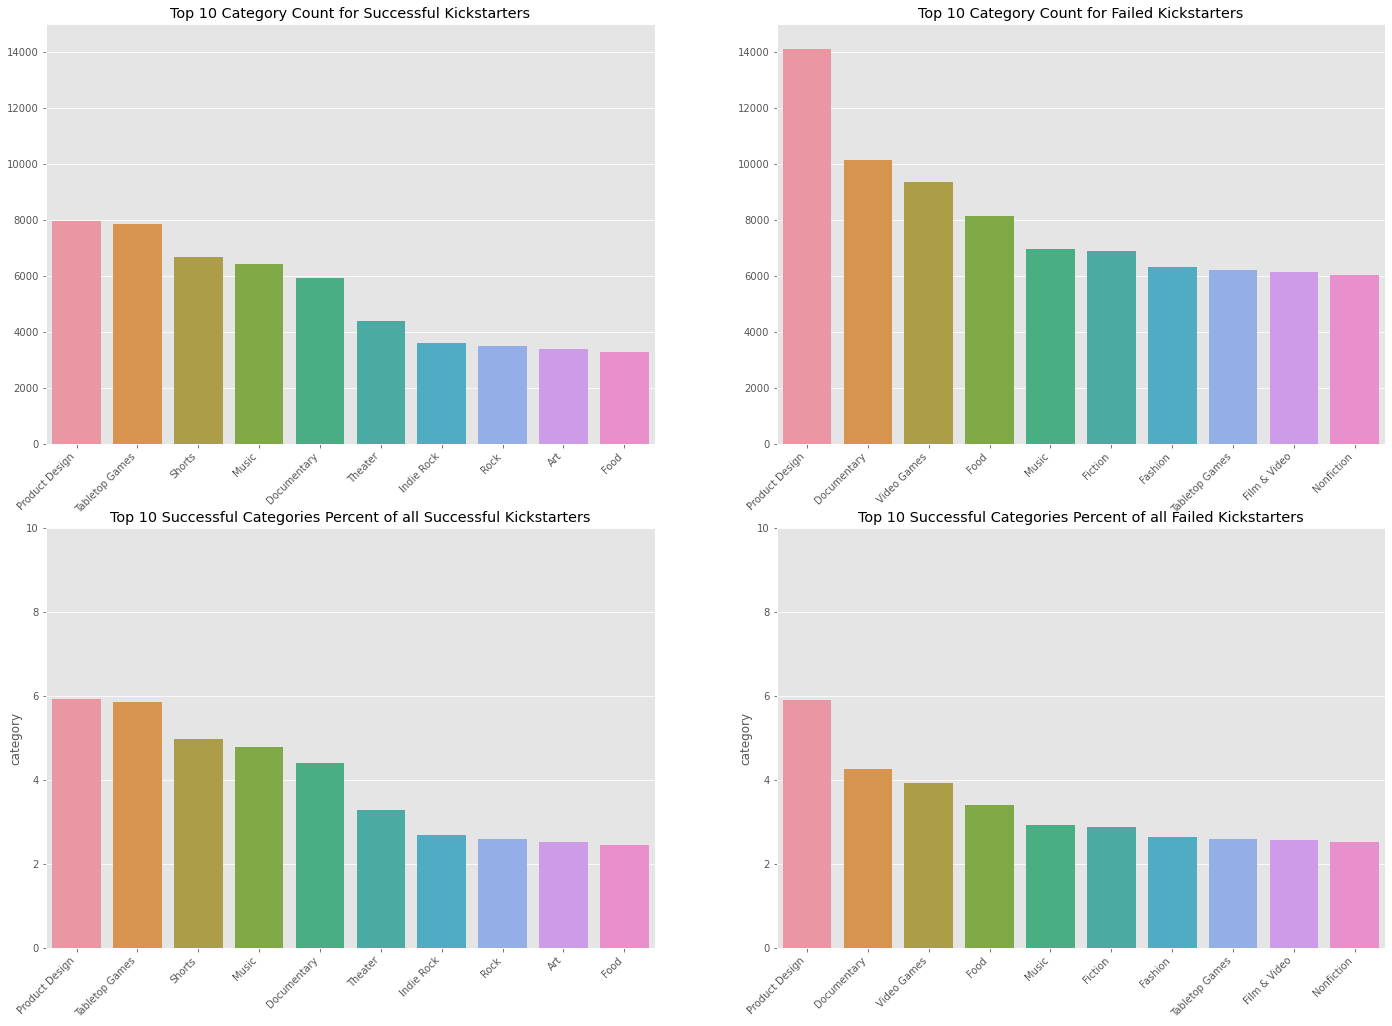

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (24, 17))

sns.barplot(x = cat_success[0:10].keys(), y = cat_success.values[0:10], ax = ax1[0])
ax1[0].set_xticklabels(ax1[0].get_xticklabels(), rotation = 45, ha = "right")
ax1[0].set_ylim(0, 15000)
ax1[0].set_title("Top 10 Category Count for Successful Kickstarters")

sns.barplot(x = cat_failed[0:10].keys(), y = cat_failed[0:10].values, ax = ax1[1])
ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation = 45, ha = "right")
ax1[1].set_ylim(0, 15000)
ax1[1].set_title("Top 10 Category Count for Failed Kickstarters")

pct_cat_success = round(cat_success[0:10] / cat_success.sum() * 100, 2)
pct_cat_failed = round(cat_failed[0:10] / cat_failed.sum() * 100, 2)

sns.barplot(x = cat_success[0:10].keys(), y = pct_cat_success, ax = ax2[0])
ax2[0].set_xticklabels(ax2[0].get_xticklabels(), rotation = 45, ha = "right")
ax2[0].set_ylim(0, 10)
ax2[0].set_title("Top 10 Successful Categories Percent of all Successful Kickstarters")

sns.barplot(x = cat_failed[0:10].keys(), y = pct_cat_failed, ax = ax2[1])
ax2[1].set_xticklabels(ax2[1].get_xticklabels(), rotation = 45, ha = "right")
ax2[1].set_ylim(0, 10)
ax2[1].set_title("Top 10 Successful Categories Percent of all Failed Kickstarters")

There are significant differences in the representation of categories (but not all categories) among successful and failed kickstarters

## Pledge Difference by Category

In [28]:
# Get all kickstarters who have a category in the top 10 most successful categories
T10_success = df[df["category"].isin(cat_success[0:10].index.values)][["category", "pledged_log", "state"]]
T10_success.head()

,category,pledged_log,state
3,Music,0.693147,failed
6,Food,7.095064,successful
8,Product Design,9.016027,failed
9,Documentary,8.738987,failed
11,Indie Rock,9.449436,successful


In [29]:
T10_failed = df[df["category"].isin(cat_failed[0:10].index.values)][["category", "pledged_log", "state"]]
T10_failed.head()

,category,pledged_log,state
3,Music,0.693147,failed
4,Film & Video,7.157735,failed
6,Food,7.095064,successful
8,Product Design,9.016027,failed
9,Documentary,8.738987,failed


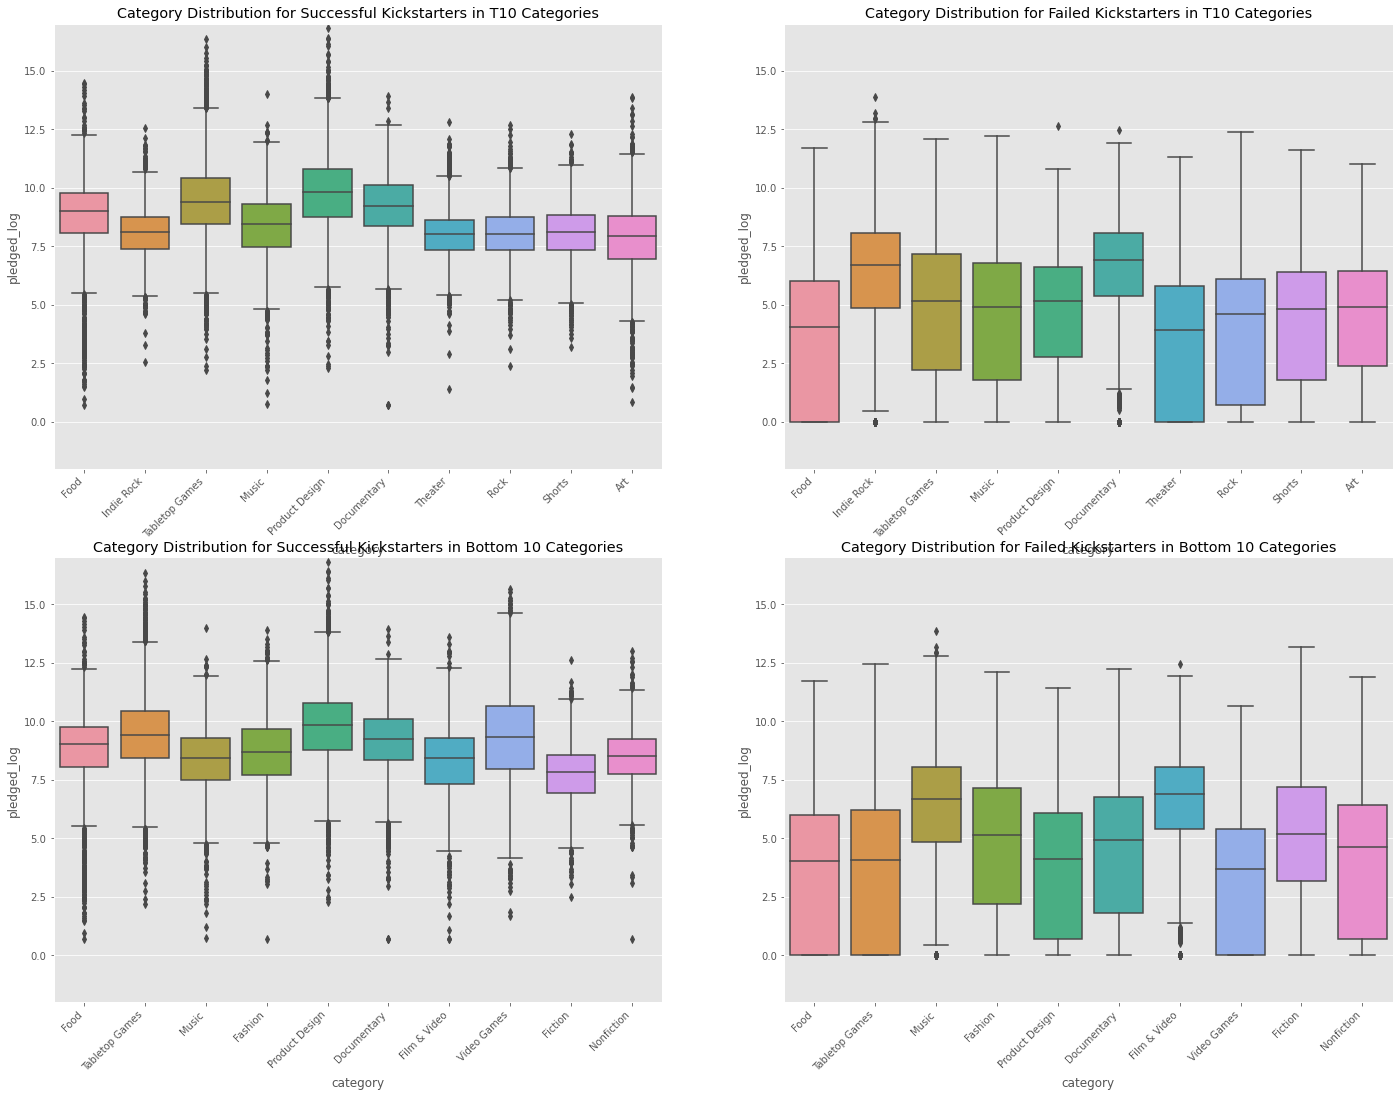

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (24, 18))

sns.boxplot(data = T10_success[T10_success["state"] == "successful"], x = "category", y = "pledged_log", ax = ax1[0])
ax1[0].set_xticklabels(ax1[0].get_xticklabels(), rotation = 45, ha = "right")
ax1[0].set_title("Category Distribution for Successful Kickstarters in T10 Categories")
ax1[0].set_ylim(-2, 17)

sns.boxplot(data = T10_success[T10_success["state"] == "failed"], x = "category", y = "pledged_log", ax = ax1[1])
ax1[1].set_xticklabels(ax1[0].get_xticklabels(), rotation = 45, ha = "right")
ax1[1].set_title("Category Distribution for Failed Kickstarters in T10 Categories")
ax1[1].set_ylim(-2, 17)

sns.boxplot(data = T10_failed[T10_failed["state"] == "successful"], x = "category", y = "pledged_log", ax = ax2[0])
ax2[0].set_xticklabels(ax2[0].get_xticklabels(), rotation = 45, ha = "right")
ax2[0].set_title("Category Distribution for Successful Kickstarters in Bottom 10 Categories")
ax2[0].set_ylim(-2, 17)

sns.boxplot(data = T10_failed[T10_failed["state"] == "failed"], x = "category", y = "pledged_log", ax = ax2[1])
ax2[1].set_xticklabels(ax2[0].get_xticklabels(), rotation = 45, ha = "right")
ax2[1].set_title("Category Distribution for Failed Kickstarters in Bottom 10 Categories")
ax2[1].set_ylim(-2, 17)

plt.show()

Boxplots show that, for both the top and bottom 10 most successful categories, the successful kickstarters have similar pledge distributions across categories, whereas failed kickstarter categories have more variant and wider pledge distributions.  

#### Launch Date and Deadline

In [31]:
from datetime import datetime, timedelta

In [32]:
df[["launched", "deadline"]].dtypes

launched    object
deadline    object
dtype: object

In [33]:
df[["launched"]] = pd.to_datetime(df["launched"])
df[["deadline"]] = pd.to_datetime(df["deadline"])

In [34]:
df[["launched", "deadline"]].dtypes

launched    datetime64[ns]
deadline    datetime64[ns]
dtype: object

In [35]:
df["campaign_days"] = (df["deadline"] - df["launched"]).dt.days

In [36]:
df["campaign_months"] = round(df["campaign_days"] / 30, 0)

View distribution of kickstarter campaign lengths 

Text(0.5, 1.0, 'Distribution of Campaign Months')

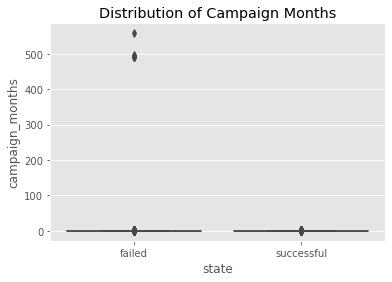

In [37]:
sns.boxplot(data = df, x = "state", y = "campaign_months")
plt.title("Distribution of Campaign Months")

In [38]:
print("There are", len(df[df["campaign_months"] > 3]), "kickstarters with campaign lengths over 3 months, and each of these have lengths over 450 months.")

There are 7 kickstarters with campaign lengths over 3 months, and each of these have lengths over 450 months.


In [39]:
df = df[df["campaign_months"] <= 3]

Text(0.5, 1.0, 'Distribution of Campaign Months by State')

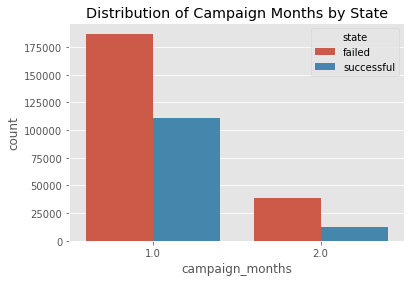

In [40]:
sns.countplot(data = df[df["campaign_months"].between(1, 2)], x = "campaign_months", hue = "state")
plt.title("Distribution of Campaign Months by State")

Most of the kickstarters, successes or failures, had campaigns that lasted 1 month. However, the ratio of successful to failed campaign is much higher for those that lasted 2 months. 

Text(0.5, 1.0, 'Distribution of Goal Amount (log) by Campaign Months')

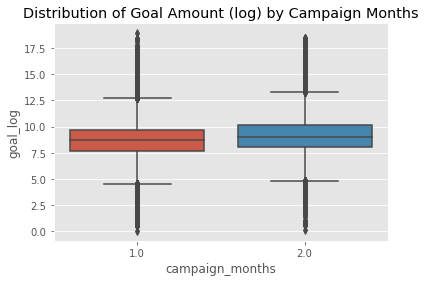

In [41]:
sns.boxplot(data = df[df["campaign_months"].between(1, 2)], x = "campaign_months", y = "goal_log")
plt.title("Distribution of Goal Amount (log) by Campaign Months")

The difference in the success:failure ratio does not appear to be a result of differences in goals, as may have been hypothesized.

In [42]:
df["state_dum"] = df["state"]
df = pd.get_dummies(df, columns = ["state_dum"], drop_first = True)

In [43]:
df.rename(columns = {"state_dum_successful":"state_dummy"}, inplace = True)

In [44]:
df["launch_year"] = pd.DatetimeIndex(df["launched"]).year

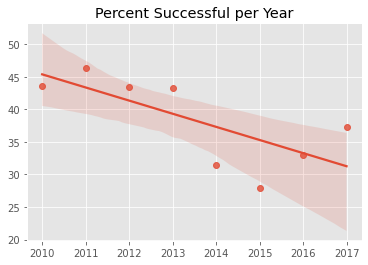

In [45]:
sns.regplot(x = np.sort(df[df["launch_year"].between(2010, 2017)]["launch_year"].unique()), 
                y = df[df["launch_year"].between(2010, 2017)].groupby("launch_year")["state_dummy"].mean().values * 100)

plt.title("Percent Successful per Year")
plt.show()

There appears to be a downward trend in the percent of total kickstarters that are successful. That trend actually does not appear linear, but intead the result of a sustained dropoff in success rate beginning in 2014 despite a moderate recovery in success rate beginning in 2016-2017. That could be a result of a larger increase in the number of kickstarter projects relative to the total amount pledged each year. 

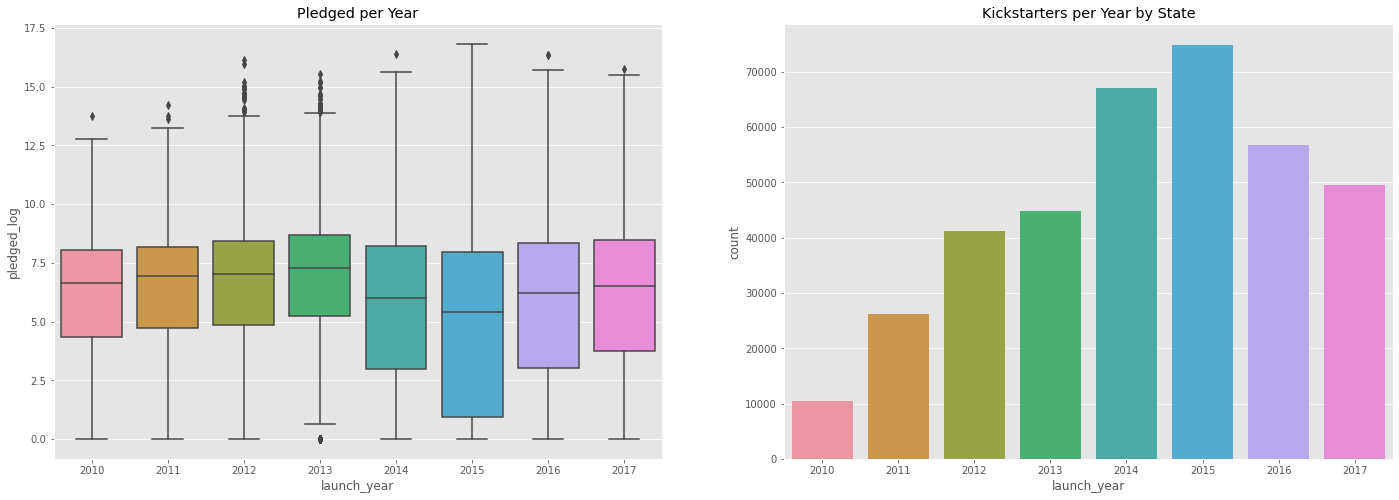

In [46]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))

sns.boxplot(data = df[df["launch_year"].between(2010, 2017)], x = "launch_year", y = "pledged_log", ax = ax[0])
ax[0].set_title("Pledged per Year")

sns.countplot(data = df[df["launch_year"].between(2010, 2017)], x = "launch_year", ax = ax[1])
ax[1].set_title("Kickstarters per Year by State")

plt.show()

The aforementioned hypothesis may have validity, as can be seen by the relative constant levels of pledging and the dramatic rise in kickstarters in 2014-2015. And, as success rate began to rise in 2016-2017, the number of kickstarters began to shrink.

#### Percent of Goal Reached / Pledged Amount as a Percent of Goal ("pledge_diff")

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


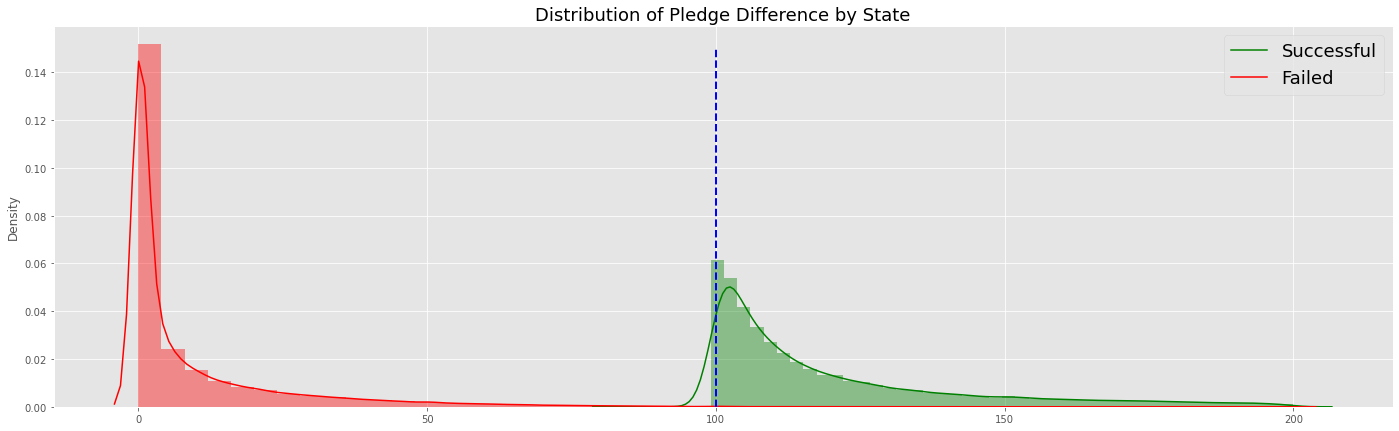

In [47]:
plt.figure(figsize = (24, 7))

sns.distplot(df[(df["pledge_diff"] < 200) & (df["state"] == "successful")]["pledge_diff"].values, color = "green")
sns.distplot(df[(df["pledge_diff"] < 200) & (df["state"] == "failed")]["pledge_diff"].values, color = "red")

plt.plot([100, 100], [0, 0.15], color = "blue", linestyle = "--", linewidth = 2)

plt.title("Distribution of Pledge Difference by State", fontsize = 18)
plt.legend(labels = ["Successful", "Failed"], fontsize = 18)

plt.show()

In [48]:
print("Failed Kickstarters: Percent of Goal Pledged")
print("")
print("25th Percentile:", df.groupby("state")["pledge_diff"].quantile(0.25)[0], "%")
print("Median:", df.groupby("state")["pledge_diff"].median()[0], "%")
print("75th Percentile:", df.groupby("state")["pledge_diff"].quantile(0.75)[0], "%")
print("--" * 40)
print("Successful Kickstarters: Percent of Goal Pledged")
print("")
print("25th Percentile:", df.groupby("state")["pledge_diff"].quantile(0.25)[1], "%")
print("Median:", df.groupby("state")["pledge_diff"].median()[1], "%")
print("75th Percentile:", df.groupby("state")["pledge_diff"].quantile(0.75)[1], "%")

Failed Kickstarters: Percent of Goal Pledged

25th Percentile: 0.02 %
Median: 1.6 %
75th Percentile: 11.0 %
--------------------------------------------------------------------------------
Successful Kickstarters: Percent of Goal Pledged

25th Percentile: 104.64 %
Median: 116.67 %
75th Percentile: 163.14 %


Most failed kickstarters never came close to reaching 100% of their goal and most successful kickstarters reached a pledged amount moderately above their goal, making both log-normally distributed.

#### Backers

While the number of backers cannot be known a priori and therefore will not be helpful in making a prediction, it is useful to understand the distribution of backers in successful and failed campaigns to know whether successful campaign are successful as a result of more backers or more pledged capital per backer.

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='backers', ylabel='Density'>

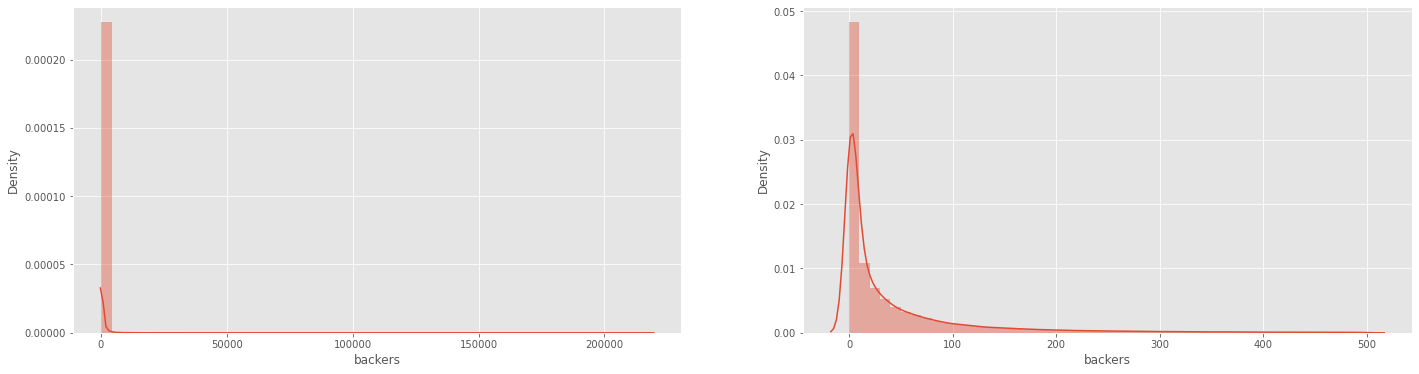

In [49]:
fig, ax = plt.subplots(1, 2, figsize = (24, 6))
sns.distplot(df["backers"], ax = ax[0])
sns.distplot(df[df["backers"] < 500]["backers"], ax = ax[1])

There is a extreme right skew, indicating that the number of backers, like the goal and pledged amounts, is logrithmically distributed. 

In [50]:
df["log_backers"] = np.log(df["backers"] + 1)

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

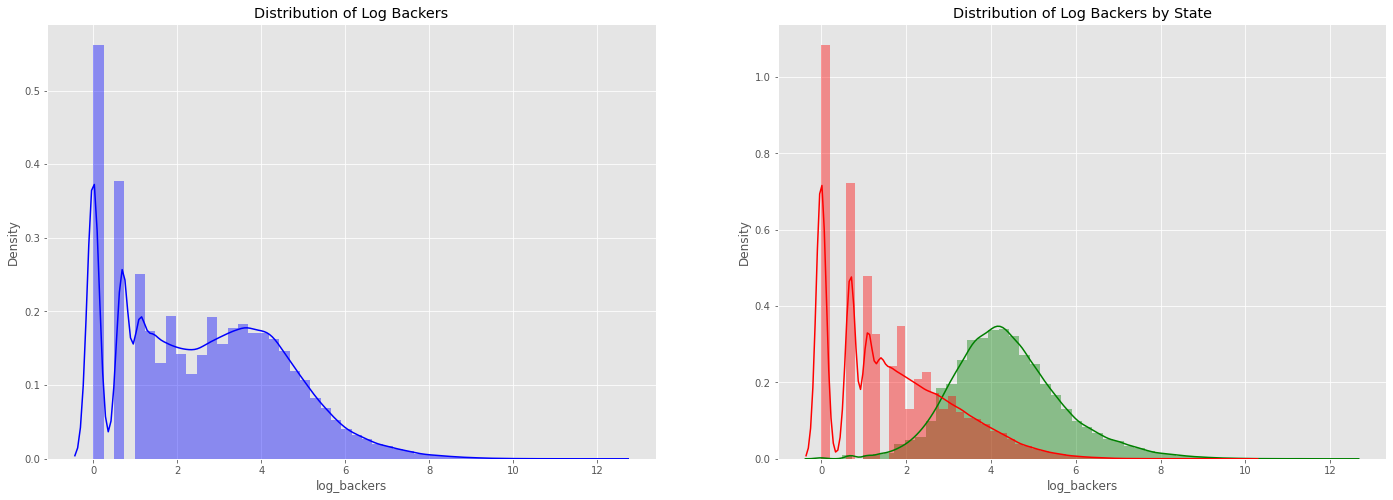

In [51]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))
sns.distplot(df["log_backers"], ax = ax[0], color = "blue")
ax[0].set_title("Distribution of Log Backers")

sns.distplot(df[df["state"] == "successful"]["log_backers"], ax = ax[1], color = "green")
sns.distplot(df[df["state"] == "failed"]["log_backers"], ax = ax[1], color = "red")
ax[1].set_title("Distribution of Log Backers by State")

plt.show()

Successful campaigns tend to have more backers, and the distribution of backers for successful campaigns is log-normally distributed, whereas the distribution of backers for failed campaigns is still skewed to the right.  

In [52]:
df["pledge_per_backer"] = round(df["usd_pledged_real"] / df["backers"], 2)

In [53]:
df["pledge_per_backer"] = df["pledge_per_backer"].fillna(0)
df["pledge_per_backer"] = df["pledge_per_backer"].replace([np.inf, -np.inf], 0) 

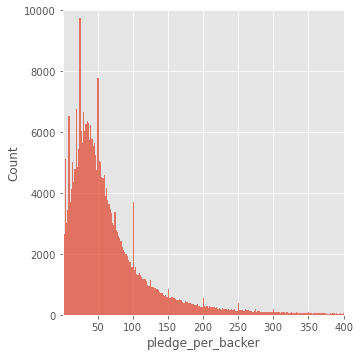

In [54]:
sns.displot(df["pledge_per_backer"])
plt.xlim(1, 400)
plt.ylim(0, 10000)

plt.show()

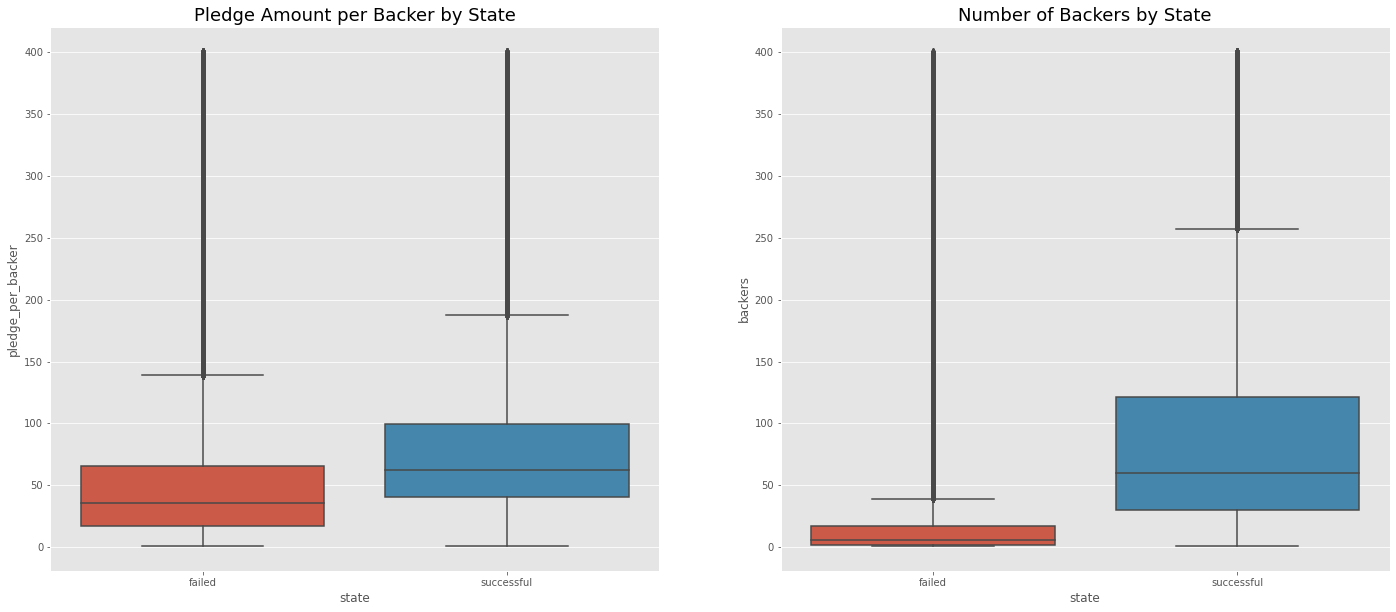

In [55]:
fig, ax = plt.subplots(1, 2, figsize = (24, 10))

sns.boxplot(data = df[df["pledge_per_backer"].between(1, 400)], x = "state", y = "pledge_per_backer", ax = ax[0])
ax[0].set_title("Pledge Amount per Backer by State", fontsize = 18)

sns.boxplot(data = df[df["backers"].between(1, 400)], x = "state", y = "backers", ax = ax[1])
ax[1].set_title("Number of Backers by State", fontsize = 18)

plt.show()

While the pledge amount per state has overlapping IQRs, the number of backers shows significant difference in the distributions of successful and failed campaigns, indicating that number of backers is more important that pledge amount per backer.

In [56]:
df["log_pledge_per_backer"] = np.log(df["pledge_per_backer"])
df["log_pledge_per_backer"] = df["log_pledge_per_backer"].fillna(0)
df["log_pledge_per_backer"] = df["log_pledge_per_backer"].replace([np.inf, -np.inf], 0) 

C:\Users\ikant\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


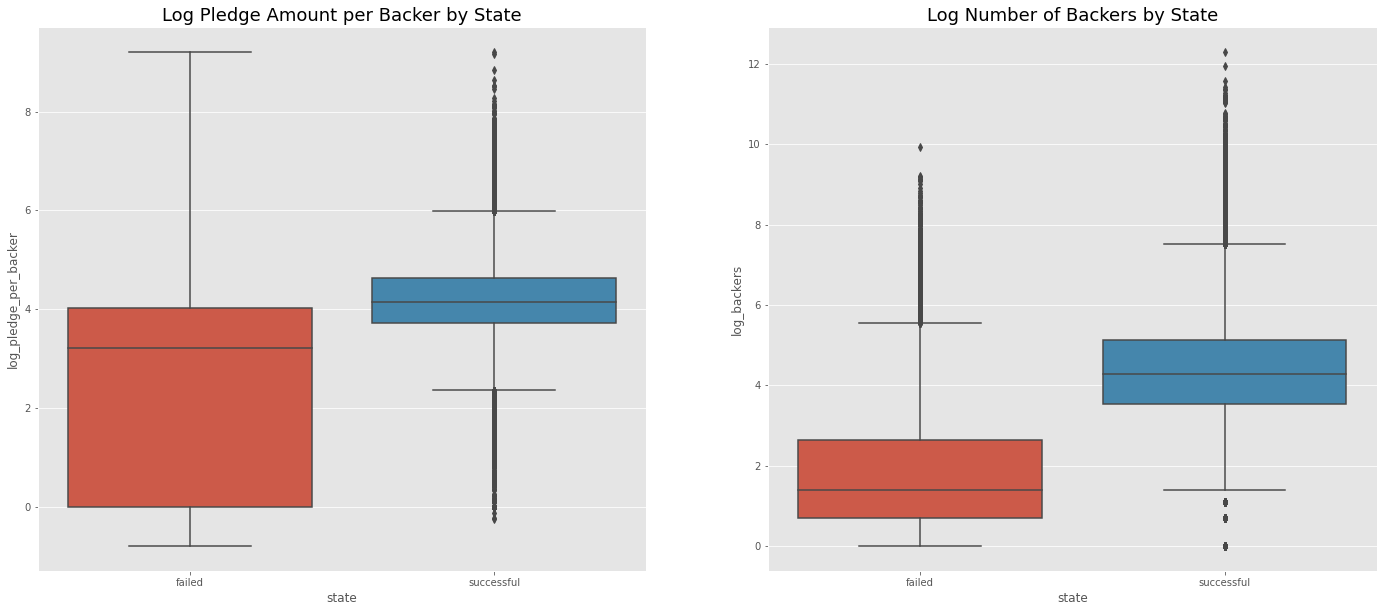

In [57]:
fig, ax = plt.subplots(1, 2, figsize = (24, 10))

sns.boxplot(data = df, x = "state", y = "log_pledge_per_backer", ax = ax[0])
ax[0].set_title("Log Pledge Amount per Backer by State", fontsize = 18)

sns.boxplot(data = df, x = "state", y = "log_backers", ax = ax[1])
ax[1].set_title("Log Number of Backers by State", fontsize = 18)

plt.show()

Log Analysis confirms that number of backers appears more important that pledge per backer. However, that is not to say that the impact of pledge amount per backer is not significant and, therefore, worth including in the model.

#### Country

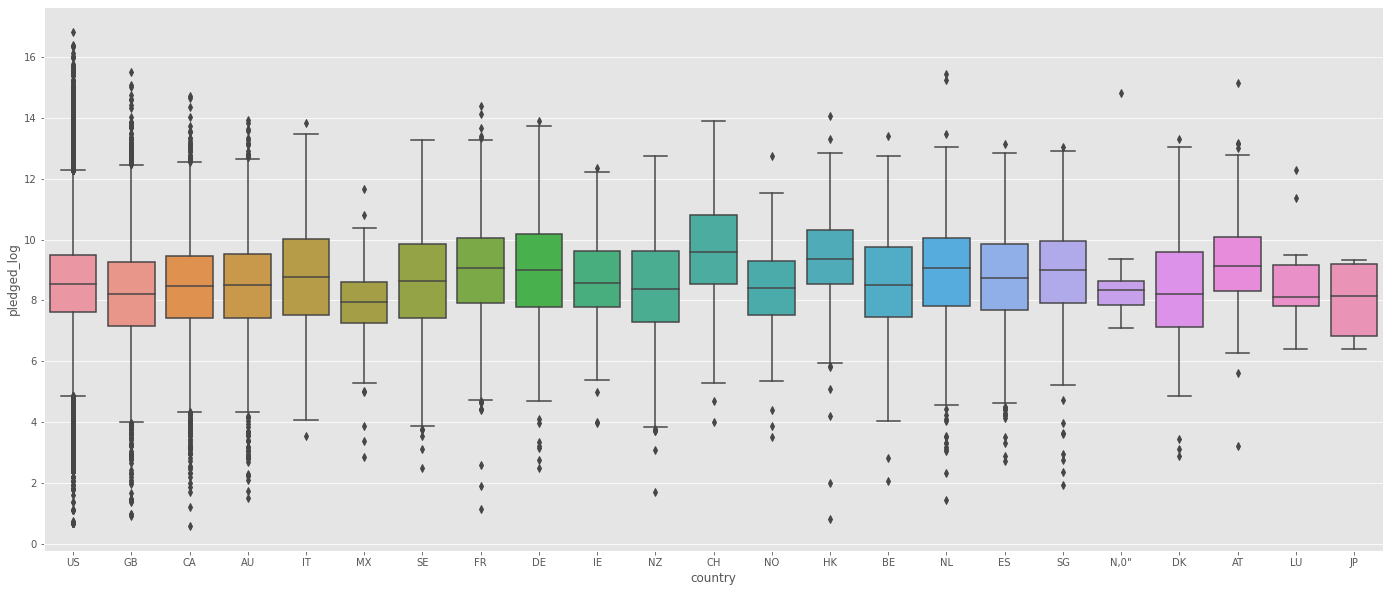

In [58]:
plt.figure(figsize = (24, 10))

sns.boxplot(data = df[df["state"] == "successful"], 
            x = "country", y = "pledged_log")

plt.show()

In [59]:
df.groupby("country")["state_dummy"].count().sort_values(ascending = False)

country
US      290881
GB       33393
CA       14624
AU        7769
DE        4096
FR        2887
NL        2833
IT        2802
ES        2224
SE        1737
MX        1645
NZ        1436
DK        1097
IE         800
CH         746
NO         700
BE         605
HK         583
AT         582
SG         527
N,0"       234
LU          61
JP          31
Name: state_dummy, dtype: int64

In [60]:
df.groupby("country")["state_dummy"].mean().sort_values(ascending = False)

country
N,0"    0.448718
US      0.375752
HK      0.370497
GB      0.361363
SG      0.337761
DK      0.328168
FR      0.314513
NZ      0.311978
LU      0.311475
SE      0.293034
CA      0.282686
IE      0.258750
AU      0.258721
BE      0.251240
CH      0.250670
MX      0.240729
NO      0.231429
DE      0.228760
JP      0.225806
ES      0.221223
NL      0.217790
AT      0.183849
IT      0.156674
Name: state_dummy, dtype: float64

There are significant differences between the mean success rates of campaigns in different countries and sampling is heavily weighted toward US based campaigns.

## Feature Engineering

Narraw dataset to only include US-based companies

In [61]:
df_features = df[df["country"] == "US"]

Create new dataframe for only relevant features for modeling

In [62]:
df_features = df_features[["state_dummy", "main_category", "category", "usd_goal_real", "launched", "deadline"]]

In [63]:
df_features.head()

,state_dummy,main_category,category,usd_goal_real,launched,deadline
1,0,Film & Video,Narrative Film,30000.0,2017-09-02 04:43:57,2017-11-01
2,0,Film & Video,Narrative Film,45000.0,2013-01-12 00:20:50,2013-02-26
3,0,Music,Music,5000.0,2012-03-17 03:24:11,2012-04-16
4,0,Film & Video,Film & Video,19500.0,2015-07-04 08:35:03,2015-08-29
5,1,Food,Restaurants,50000.0,2016-02-26 13:38:27,2016-04-01


Note: features related to number of backers and pledged amount were removed from feature set because they cannot be known a priori and therefore should not be used in a model to predict kickstarter success

Used "launched" and "deadline" columns to derive useful numerical columns for modeling

In [64]:
# Create column of the minimum launch date from the dataset 
df_features["min_date"] = df_features["launched"].min()

# Create a column of the number of days between the minimum launch date and the date of each samples launch 
days_list  = []

for i, row in df_features.iterrows():
    days_list.append((df["launched"][i] - df_features["min_date"][i]).days)
    
df_features["launch_days"] = days_list

In [65]:
df_features["launch_year"] = df_features.launched.dt.year
df_features["deadline_year"] = df_features.deadline.dt.year
df_features["launch_month"] = df_features.launched.dt.month
df_features["deadline_month"] = df_features.deadline.dt.month

In [66]:
df_features.drop(["launched", "deadline", "min_date"], axis = 1, inplace = True)

Rename state dummy column

In [67]:
df_features.rename(columns = {"state_dummy" : "state"}, inplace = True)

In [68]:
df_features.head()

,state,main_category,category,usd_goal_real,launch_days,launch_year,deadline_year,launch_month,deadline_month
1,0,Film & Video,Narrative Film,30000.0,3055,2017,2017,9,11
2,0,Film & Video,Narrative Film,45000.0,1361,2013,2013,1,2
3,0,Music,Music,5000.0,1060,2012,2012,3,4
4,0,Film & Video,Film & Video,19500.0,2264,2015,2015,7,8
5,1,Food,Restaurants,50000.0,2501,2016,2016,2,4


Set dummy variables for categories and main categories

In [69]:
print("Dataframe shape BEFORE dummy transformation:", df_features.shape)

df_features = pd.get_dummies(df_features, columns = ["category", "main_category"], drop_first = True)

print("Dataframe shape AFTER dummy transformation:", df_features.shape)

Dataframe shape BEFORE dummy transformation: (290881, 9)
Dataframe shape AFTER dummy transformation: (290881, 179)


Create target array and scaled feature array

In [70]:
Y = df_features["state"].values
Y[0:5]

array([0, 0, 0, 0, 1], dtype=uint8)

In [71]:
from sklearn.preprocessing import StandardScaler

In [72]:
X = df_features.drop("state", axis = 1).values
X = StandardScaler().fit(X).transform(X) 
X[0]

array([-1.25835893e-02,  1.66828528e+00,  1.56857786e+00,  1.54479913e+00,
        7.95389565e-01,  1.29670718e+00, -4.59923238e-02, -8.24910272e-02,
       -4.26031196e-02, -2.30899989e-02, -8.36448975e-02, -4.41934127e-02,
       -1.34186928e-01, -1.16119782e-01, -4.21962529e-02, -1.50624167e-01,
       -8.41850093e-02, -3.38542480e-02, -2.38236064e-02, -2.54984841e-02,
       -2.83742902e-02, -3.20238122e-02, -3.40065783e-02, -2.90340980e-02,
       -1.39838183e-01, -3.52505245e-02, -8.89249053e-03, -2.76988215e-02,
       -8.65145093e-02, -7.62631259e-02, -8.47834960e-02, -1.24458582e-01,
       -2.86760787e-02, -5.29087323e-02, -3.51035673e-02, -1.19331628e-01,
       -2.41820842e-02, -1.11105891e-01, -1.98006692e-02, -5.53366323e-02,
       -4.36433526e-02, -8.55615633e-02, -1.00977184e-01, -5.81119890e-02,
       -2.21800108e-01, -6.92429719e-02, -7.91732252e-02, -7.26209241e-02,
       -1.57348398e-02, -4.53878688e-02, -4.56910875e-02, -2.29404686e-02,
       -5.69996427e-02, -

## Model Selection and Training

In [73]:
from sklearn.model_selection import GridSearchCV

In [74]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#### Cross Validation

In [75]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [76]:
classifiers = {
    "Logistic Regression" : LogisticRegression(n_jobs = -1),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(n_estimators = 200, n_jobs = -1),
    #"Gradient Boosting Classifier" : GradientBoostingClassifier(n_estimators = 200),
    #"Ridge Classifier" : RidgeClassifier(),
    #"Bagging Ridge Classifier" : BaggingClassifier(n_jobs = -1),
    #"Extra Trees Classifier" : ExtraTreesClassifier,
    #"Support Vector Machine" : SVC(),
    #"K-Nearest Neighbors" : KNeighborsClassifier(n_jobs = -1)
}

In [77]:
from sklearn.model_selection import cross_val_score

names = []
accuracies = []

print("Classifier Accuracies")
print("")

for name, model in classifiers.items():
    
    # For each classifier, get the accuracies of each cross validation 
    cross_val = cross_val_score(model, x_train, y_train, cv = 5, scoring = "roc_auc", n_jobs = -1)
    
    # Append the classifier names to a list (names) and the list of accuracies for each classifier to a list (accuracies) 
    names.append(name)
    accuracies.append(cross_val)
    
    # Print cross validation results
    print("%s: %f (+/- %f)" % (name, cross_val.mean(),  cross_val.std()))

Classifier Accuracies

Logistic Regression: 0.705238 (+/- 0.000929)
Decision Tree: 0.581174 (+/- 0.002091)
Random Forest: 0.670344 (+/- 0.001740)


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

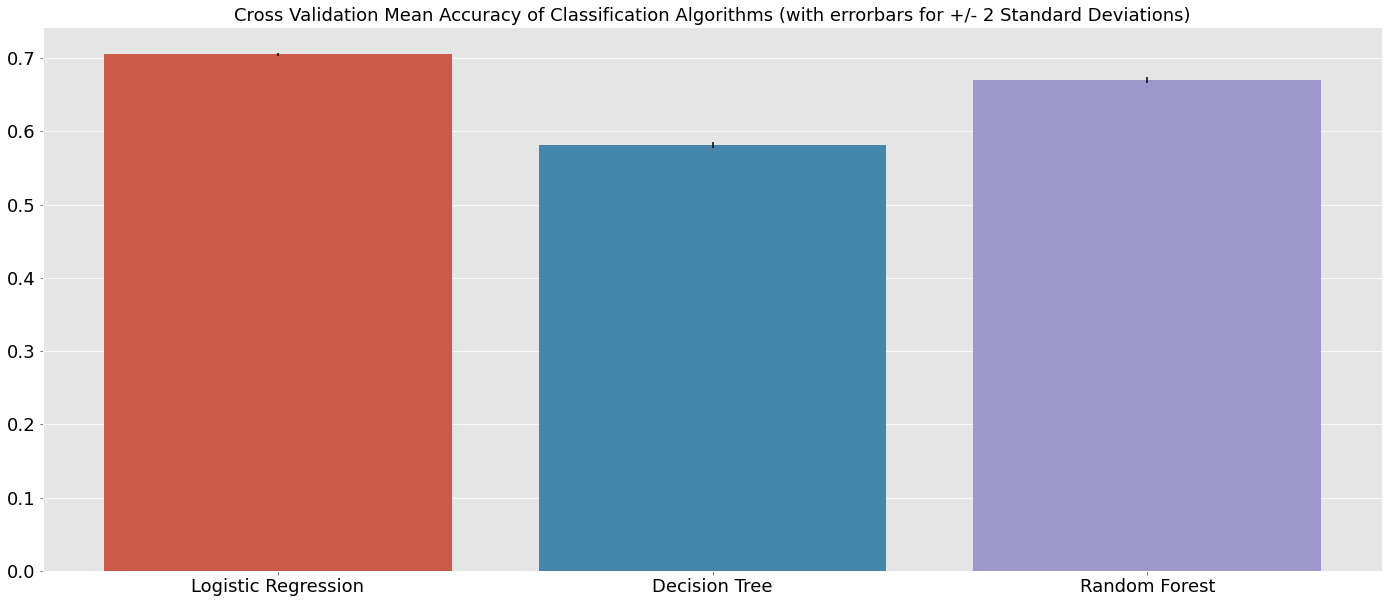

In [78]:
mean_acc = [accuracies[0].mean(), accuracies[1].mean(), accuracies[2].mean()]
std_acc = [accuracies[0].std() * 2, accuracies[1].std() * 2, accuracies[2].std() * 2]

plt.figure(figsize = (24, 10))
sns.barplot(x = names, y = mean_acc)
plt.errorbar(x = names, y = mean_acc, yerr = std_acc, fmt = "none", c = "k")
plt.title("Cross Validation Mean Accuracy of Classification Algorithms (with errorbars for +/- 2 Standard Deviations)", fontsize = 18)
plt.xticks(fontsize = 18, c = "k")
plt.yticks(fontsize = 18, c = "k")

In [79]:
from sklearn.metrics import roc_auc_score

def model_eval(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    yhat = model.predict(x_test)
    score = roc_auc_score(y_test, yhat)
    return yhat, score

#### Logistic Regression

In [80]:
LogReg = LogisticRegression()
LogReg_yhat, LogReg_score = model_eval(LogReg, x_train, y_train, x_test, y_test)
print("ROC AUC Score of Logistic Regression Model =", LogReg_score)

C:\Users\ikant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC Score of Logistic Regression Model = 0.617649992406394


In [82]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report

print("Recall Score = {:.2f}".format(recall_score(y_test, LogReg_yhat)))
print("Precision Score = {:.2f}".format(precision_score(y_test, LogReg_yhat)))
print("F1 Score = {:.2f}".format(f1_score(y_test, LogReg_yhat)))
print("Accuracy Score = {:.2f}".format(accuracy_score(y_test, LogReg_yhat)))
print("")
print("Classification Report")
print("")
print(classification_report(y_test, LogReg_yhat))

Recall Score = 0.40
Precision Score = 0.60
F1 Score = 0.48
Accuracy Score = 0.67

Classification Report

              precision    recall  f1-score   support

           0       0.70      0.84      0.76     36262
           1       0.60      0.40      0.48     21915

    accuracy                           0.67     58177
   macro avg       0.65      0.62      0.62     58177
weighted avg       0.66      0.67      0.65     58177



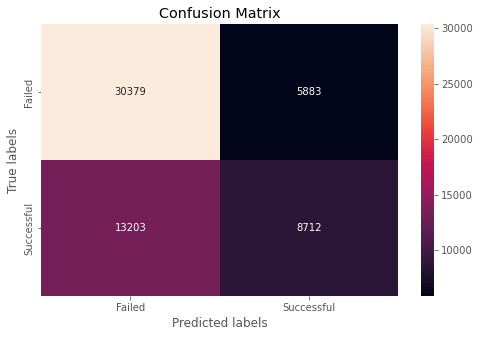

In [89]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, yhat):
    cm = confusion_matrix(y_test, yhat)
    fig = plt.figure(figsize = (8, 5))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = "g");
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(["Failed", "Successful"]); ax.yaxis.set_ticklabels(["Failed", "Successful"])
    
plot_confusion_matrix(y_test, LogReg_yhat)

**Recall:** The Logisitic Regression model predicts Failed kickstarters accurately as failed 84% of the time; however, the model only predicts Successful kickstarters accurately as successful 40% of the time. 

**Precision:** The Logisitic Regression model's predictions for Failed kickstarters 70% accurate; however, the model's Successful predictions were only accurate 60% of the time. 

#### Random Forest

In [81]:
RandFor = RandomForestClassifier(n_estimators = 200, n_jobs = -1)
RandFor_yhat, RandFor_score = model_eval(RandFor, x_train, y_train, x_test, y_test)
print("ROC AUC Score of Random Forest Classifier Model =", RandFor_score)

ROC AUC Score of Random Forest Classifier Model = 0.6122806598309488


In [83]:
print("Recall Score = {:.2f}".format(recall_score(y_test, RandFor_yhat)))
print("Precision Score = {:.2f}".format(precision_score(y_test, RandFor_yhat)))
print("F1 Score = {:.2f}".format(f1_score(y_test, RandFor_yhat)))
print("Accuracy Score = {:.2f}".format(accuracy_score(y_test, RandFor_yhat)))
print("")
print("Classification Report")
print("")
print(classification_report(y_test, RandFor_yhat))

Recall Score = 0.47
Precision Score = 0.54
F1 Score = 0.50
Accuracy Score = 0.65

Classification Report

              precision    recall  f1-score   support

           0       0.70      0.75      0.73     36262
           1       0.54      0.47      0.50     21915

    accuracy                           0.65     58177
   macro avg       0.62      0.61      0.61     58177
weighted avg       0.64      0.65      0.64     58177



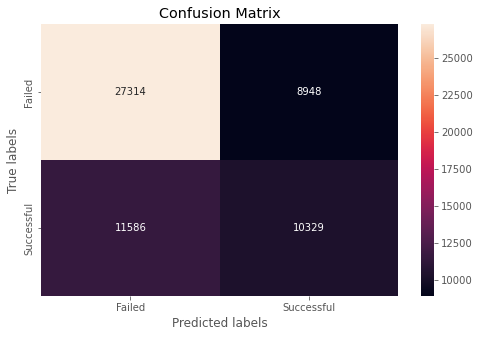

In [99]:
plot_confusion_matrix(y_test, RandFor_yhat)

**Recall:** The Random Forest model predicts Failed kickstarters accurately as failed 75% of the time; however, the model only predicts Successful kickstarters accurately as successful 47% of the time. 

**Precision:** The Logisitic Regression model's predictions for Failed kickstarters 70% accurate; however, the model's Successful predictions were only accurate 54% of the time. 